# Machine Learning Library Strategy

In [1]:
import os
import sys
from pathlib import Path

from IPython.display import display, HTML, Markdown
import numpy as np
import pandas as pd

from dask import dataframe as dd
from dask import delayed
from dask.distributed import Client

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Project level imports
sys.path.insert(0, '../lib')
from ncbi_remap.plotting import make_figs
from ncbi_remap.normalization import cpm

# Connect to data store
store = pd.HDFStore('../output/sra.h5', mode='r')
samples = store['aln/complete'].srx.unique().tolist()

In [2]:
from pymongo import MongoClient
try:
    with open('../output/.mongodb_host', 'r') as fh:
        host = fh.read().strip()
except FileNotFoundError:
    host = 'localhost'

mongoClient = MongoClient(host=host, port=27017)
db = mongoClient['sramongo']
ncbi = db['ncbi']

In [3]:
labels = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': samples}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'library_strategy': '$sra.experiment.library_strategy'
        }
    }
    
])))
labels.set_index('srx', inplace=True)
labels.head()

,library_strategy
srx,
DRX000774,OTHER
DRX000775,OTHER
DRX000998,WGS
DRX000999,WGS
DRX001000,WGS


In [56]:
labels.library_strategy.value_counts()

RNA-Seq                   13829
EST                        4546
ChIP-Seq                   3003
OTHER                      2572
WGS                        1970
miRNA-Seq                   131
MNase-Seq                   116
Targeted-Capture             96
AMPLICON                     86
ncRNA-Seq                    69
RIP-Seq                      58
FAIRE-seq                    19
DNase-Hypersensitivity       10
POOLCLONE                     8
CLONEEND                      7
FL-cDNA                       7
WGA                           6
MeDIP-Seq                     6
Bisulfite-Seq                 5
CLONE                         1
Name: library_strategy, dtype: int64

## Normalized read counts

In [4]:
df = pd.read_parquet('../output/downstream-analysis/counts_norm_median.parquet')
data = df.join(labels)

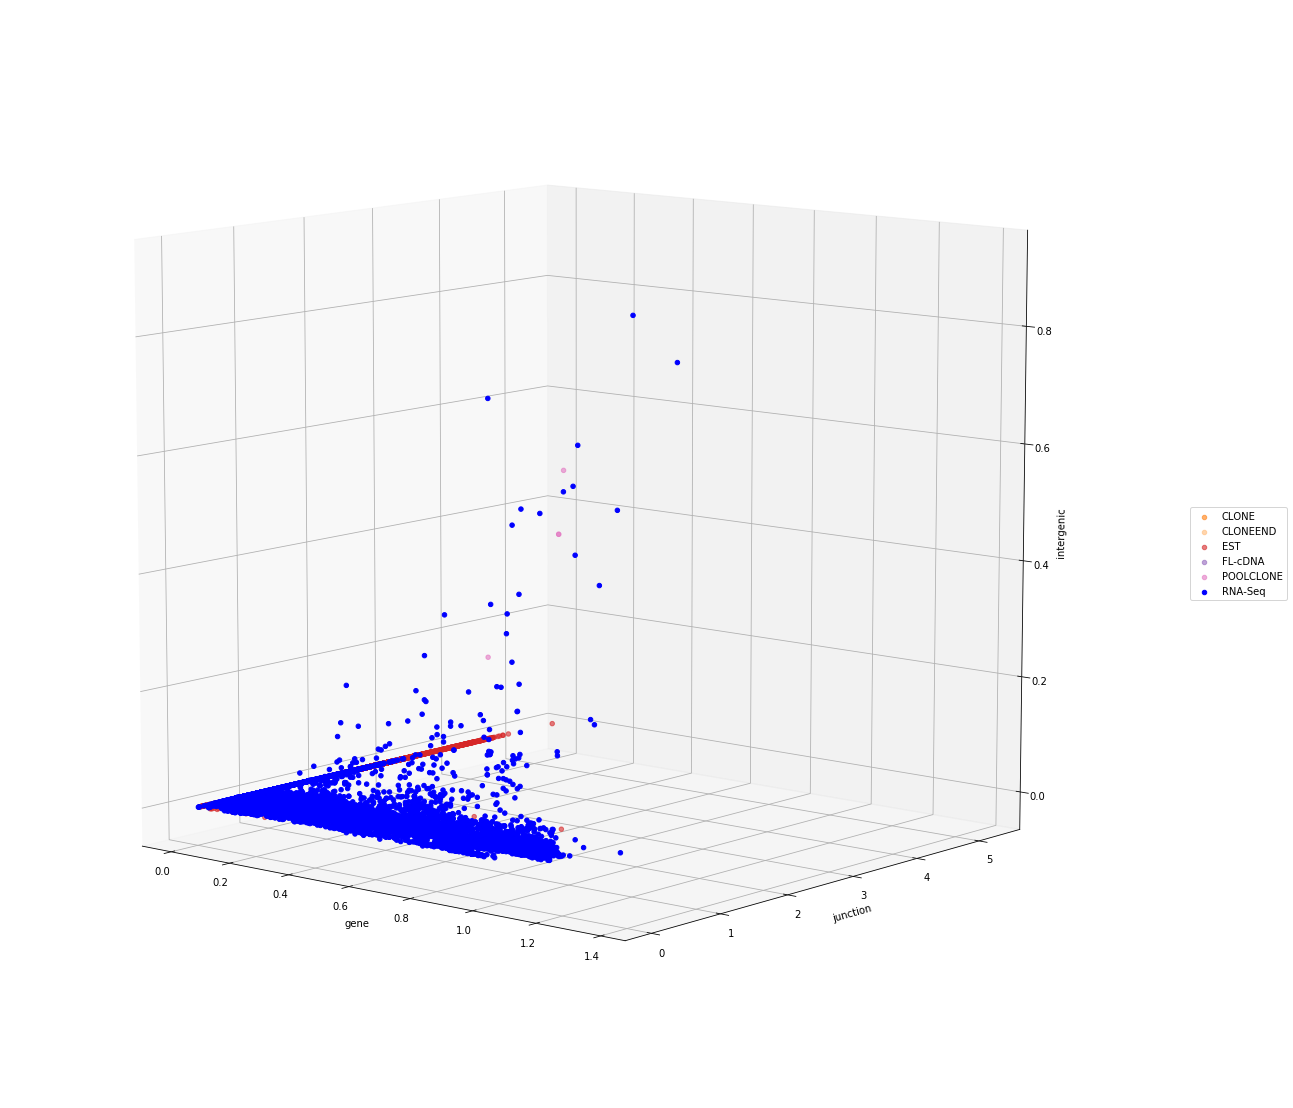

In [54]:
fig = plt.figure(figsize=(20, 20))
ax = fig.add_subplot(111, projection='3d')

for (g, _dd), color in zip(data.groupby('library_strategy'), sns.color_palette('tab20', n_colors=20)):
    if g in ['WGS', 'MNase-Seq', 'OTHER', 'miRNA-Seq', 'ChIP-Seq', 'AMPLICON', 
             'ncRNA-Seq', 'FAIRE-seq', 'Targeted-Capture', 'RIP-Seq', 'MeDIP-Seq',
             'AMPLICON', 'Bisulfite-Seq', 'DNase-Hypersensitivity', 'WGA',
            ]:
        continue
    if g == 'RNA-Seq':
        alpha=1
        color='b'
    else:
        alpha=.6
        
    ax.scatter(_dd.gene, _dd.junction, _dd.intergenic, label=g, alpha=alpha, c=color)
    
ax.set_xlabel('gene')
ax.set_ylabel('junction')
ax.set_zlabel('intergenic')
plt.legend(loc='center', bbox_to_anchor=(1.1, 0.5))
ax.elev = ax.elev - 20
ax.azim = ax.azim + 10

## Focus on RNA-Seq

In [21]:
rnaseq = labels.query('library_strategy == "RNA-Seq"').index.tolist()

In [22]:
len(rnaseq)

13829

In [8]:
def munge_contact(values):
    res = []
    for v in values:
        if v in [np.nan, [], {}, [[]], [{}], [[{}]]]:
            res.append(np.nan)
            continue
            
        contact = v[0][0]
        if contact:
            first = contact.get('first_name', '')
            last = contact.get('last_name', '')
            email = contact.get('email', '')
            res.append(f'{first} {last} <{email}>')
            continue
        print(v)
            
        
    return res

In [9]:
def munge_authors(values):
    res = []
    for v in values:
        if v in [np.nan, [], {}, [[]], [{}], [[{}]]]:
            res.append(np.nan)
            continue
            
        authors = v[0]
        if authors:
            auts = []
            for author in authors:
                first = author.get('first_name', '')[0]
                last = author.get('last_name', '')
                auts.append(last + first)
            res.append('|'.join(auts))
            continue
        
    return res

In [10]:
def munge_source(values):
    res = []
    for v in values:
        if v in [np.nan, [], {}, [[]], [{}], [[{}]]]:
            res.append(np.nan)
            continue
            
        attrs = v
        for attr in attrs:
            if attr['name'] == 'source_name':
                res.append(attr['value'])
                break
        else:
            res.append(np.nan)
        
    return res

In [11]:
def merge_lists(df, columns):
    for col in columns:
        if col == 'contact':
            res = munge_contact(df[col].values)
        elif col == 'pubmed_authors':
            res = munge_authors(df[col].values)
        elif col == 'source name':
            res = munge_source(df[col].values)
        else:
            res = []
            for i in df[col].values:
                if isinstance(i, list):
                    res.append('|'.join(i))
                else:
                    res.append(i)
                
        df[col] = res

    return df

In [12]:
sample_sheet = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$in': rnaseq}
        }
    },
    {
        '$project': {
            '_id': 0,
            'sample_name': '$srx',
            'title': '$sra.sample.title',
            'organism': '$sra.sample.scientific_name',
            'raw files': '$srx',
            'study': '$sra.study.study_id',
            'BioProject': '$sra.study.BioProject',
            'BioSample': '$sra.sample.BioSample',
            'GEO': '$sra.study.GEO',
            'runs': '$runs.srr',
            'pubmed': '$pubmed.pubmed_id',
            'pubmed_title': '$pubmed.title',
            'pubmed_citation': '$pubmed.citation',
            'pubmed_authors': '$pubmed.authors',
            'contact': '$biosample.contacts',
            'source name': '$sra.sample.attributes',
            'molecule': '$sra.experiment.library_selection',
        }
    }
    
])))
sample_sheet.set_index('sample_name', inplace=True)

header = [
    'title', 'source name', 'organism', 'study', 'runs', 'GEO', 'BioSample', 'BioProject', 
    'pubmed', 'pubmed_title', 'pubmed_citation', 'pubmed_authors', 'contact', 
    'molecule', 'description',
    'raw files',
]

sample_sheet = merge_lists(sample_sheet, ['runs', 'pubmed', 'pubmed_title', 'pubmed_citation', 'contact', 'pubmed_authors', 'source name'])

keywords = pd.read_parquet('../output/notebook/2018-06-26_bow_keywords.parquet')
keywords.columns = ['description']
sample_sheet = sample_sheet.join(keywords, how='left')

sample_sheet = sample_sheet[header].fillna('')
sample_sheet.head()

,title,source name,organism,study,runs,GEO,BioSample,BioProject,pubmed,pubmed_title,pubmed_citation,pubmed_authors,contact,molecule,description,raw files
sample_name,,,,,,,,,,,,,,,,
DRX013093,Penicillium-fungus uninfected 3rd instar larva...,,Drosophila melanogaster,DRP001295,DRR014573,,SAMD00010225,PRJDB2332,24151578,Extensive differences in antifungal immune res...,2314-436X 2013 Int J Genomics 2013,SetoY|TamuraK,,cDNA,dextrose|sabouraud|twenty|agar|3rd|uninfected|...,DRX013093
DRX013094,Penicillium-fungus infected 3rd instar larvae ...,,Drosophila melanogaster,DRP001295,DRR014574,,SAMD00010224,PRJDB2332,24151578,Extensive differences in antifungal immune res...,2314-436X 2013 Int J Genomics 2013,SetoY|TamuraK,,cDNA,dextrose|sabouraud|twenty|agar|3rd|medium|inst...,DRX013094
DRX014765,3rd instar female larvae of Drosophila melanog...,,Drosophila melanogaster,DRP001802,DRR016398,,SAMD00013956,PRJDB2720,,,,,,RANDOM,drs014299|larva|3rd,DRX014765
DRX014766,3rd instar female larvae of Drosophila melanog...,,Drosophila melanogaster,DRP001802,DRR016399,,SAMD00013956,PRJDB2720,,,,,,RANDOM,drs014299|larva|3rd,DRX014766
DRX014767,3rd instar male larvae of Drosophila melanogas...,,Drosophila melanogaster,DRP001802,DRR016400,,SAMD00013950,PRJDB2720,,,,,,RANDOM,drs014300|larva|3rd,DRX014767


In [13]:
sample_sheet.to_csv('../output/notebook/2018-06-28_example_sample_sheet.tsv', sep='\t')

In [46]:
sample_sheet[sample_sheet.contact.str.contains('Oliver') | sample_sheet.pubmed_authors.str.contains('LeeH')]

,title,source name,organism,study,runs,GEO,BioSample,BioProject,pubmed,pubmed_title,pubmed_citation,pubmed_authors,contact,molecule,description,raw files
sample_name,,,,,,,,,,,,,,,,
SRX1329122,ED1004_25163_FEMALE_rep1,whole animal,Drosophila melanogaster,SRP064744,SRR2627812,GSE73920,SAMN04160363,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,female|whole|adult|animal,SRX1329122
SRX1329123,ED1004_25163_FEMALE_rep2,whole animal,Drosophila melanogaster,SRP064744,SRR2627813,GSE73920,SAMN04160364,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,female|whole|adult|animal,SRX1329123
SRX1329124,ED1004_25163_FEMALE_rep3,whole animal,Drosophila melanogaster,SRP064744,SRR2627814,GSE73920,SAMN04160365,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,female|whole|adult|animal,SRX1329124
SRX1329125,ED1004_25163_MALE_rep1,whole animal,Drosophila melanogaster,SRP064744,SRR2627815,GSE73920,SAMN04160366,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,male|whole|adult|animal,SRX1329125
SRX1329126,ED1004_25163_MALE_rep2,whole animal,Drosophila melanogaster,SRP064744,SRR2627816,GSE73920,SAMN04160367,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,male|whole|adult|animal,SRX1329126
SRX1329127,ED1004_25163_MALE_rep3,whole animal,Drosophila melanogaster,SRP064744,SRR2627817,GSE73920,SAMN04160560,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,male|whole|adult|animal,SRX1329127
SRX1329128,ED1050_8946_FEMALE_rep1,whole animal,Drosophila melanogaster,SRP064744,SRR2627818,GSE73920,SAMN04160571,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,female|whole|adult|animal,SRX1329128
SRX1329129,ED1050_8946_FEMALE_rep2,whole animal,Drosophila melanogaster,SRP064744,SRR2627819,GSE73920,SAMN04160368,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,female|whole|adult|animal,SRX1329129
SRX1329130,ED1050_8946_FEMALE_rep3,whole animal,Drosophila melanogaster,SRP064744,SRR2627820,GSE73920,SAMN04160369,PRJNA298537,27599372,"Effects of Gene Dose, Chromatin, and Network T...",1553-7404 12 PLoS Genet. 2016,LeeH|ChoD|WhitworthC|EismanR|PhelpsM|RooteJ|Ka...,Brian Oliver <briano@helix.nih.gov>,cDNA,female|whole|adult|animal,SRX1329130


In [38]:
sample_sheet.groupby().size().sort_values(ascending=False)

contact
Brian Oliver <briano@helix.nih.gov>                     4705
                                                        2424
Peter Chang <peterlchang@gmail.com>                      921
Peter Combs <peter.combs@berkeley.edu>                   403
Amanda Crocker <acrocker@middlebury.edu>                 185
Fiona Ingleby <f.ingleby@sussex.ac.uk>                   179
Jin Li <jin.billy.li@stanford.edu>                       167
Wen Qu <er7989@wayne.edu>                                158
Stein Aerts <Stein.Aerts@med.kuleuven.be>                138
Sebastian Kadener <skadener@mail.huji.ac.il>             103
Peter Cherbas <cherbas@indiana.edu>                      102
Stephan Hutter <hutter@bio.lmu.de>                        99
Jun Chen <cjnankai@gmail.com>                             96
Devanjali Dutta <d.dutta@zmbh.uni-heidelberg.de>          95
Itai Yanai <yanai@technion.ac.il>                         91
Stefanie Gerstberger <sgerstberg@rockefeller.edu>         90
Xiao Chen <chxia

## Tech Flags

In [288]:
layout = store['layout'].to_frame().reset_index().groupby('srx').layout.first().to_frame()

In [293]:
strand = store['strand'].reset_index().groupby('srx').strand.first().to_frame()

In [314]:
tech_flags = pd.concat([layout, strand], axis=1, sort=True)
tech_flags.index.name = 'srx'

## Prealn flags

In [272]:
abi = store['prealn/abi_solid']
abi = store['prealn/abi_solid'].groupby('srx').srr.apply(lambda x: '|'.join(x))
abi.name = 'abi_solid'
abi = abi.to_frame()

In [266]:
download = store['prealn/download_bad'].groupby('srx').srr.apply(lambda x: '|'.join(x))
download.name = 'download_problems'
download = download.to_frame()

In [268]:
alignment = store['prealn/alignment_bad'].groupby('srx').srr.apply(lambda x: '|'.join(x))
alignment.name = 'alignment_problems'
alignment = alignment.to_frame()

In [270]:
quality_score = store['prealn/quality_scores_bad'].groupby('srx').srr.apply(lambda x: '|'.join(x))
quality_score.name = 'quality_score_problems'
quality_score = quality_score.to_frame()

In [316]:
prealn_flags = pd.concat([abi, download, alignment, quality_score], axis=1, sort=True)
prealn_flags.index.name = 'srx'

## Prealn Metrics

In [328]:
same_strand = tech_flags.query('strand == "same_strand"').index.tolist()
opposite_strand = tech_flags.query('strand == "opposite_strand"').index.tolist()
df_same_strand = store['prealn/workflow/collectrnaseqmetrics/first']['PCT_CORRECT_STRAND_READS'].loc[same_strand].groupby('srx').mean().to_frame()
df_opposite_strand = store['prealn/workflow/collectrnaseqmetrics/second']['PCT_CORRECT_STRAND_READS'].loc[opposite_strand].groupby('srx').mean().to_frame()

In [332]:
prop_correct = pd.concat([df_same_strand, df_opposite_strand])
prop_correct.columns = ['prop_reads_correct_strand']

In [357]:
pd.concat([store['prealn/workflow/collectrnaseqmetrics/unstranded']['MEDIAN_CV_COVERAGE'].groupby('srx').median(),
           store['prealn/workflow/collectrnaseqmetrics/unstranded']['MEDIAN_3PRIME_BIAS'].groupby('srx').median(),
           store['prealn/workflow/collectrnaseqmetrics/unstranded']['MEDIAN_5PRIME_BIAS'].groupby('srx').median(),
           prop_correct,
          ], axis=1, sort=True)

,MEDIAN_CV_COVERAGE,MEDIAN_3PRIME_BIAS,MEDIAN_5PRIME_BIAS,prop_reads_correct_strand
DRX000774,3.555362,0.377767,0.000000,0.500596
DRX000775,3.709965,0.187335,0.027636,0.503179
DRX000998,0.322389,0.707143,0.914538,NaN
DRX000999,0.599668,0.977702,0.961241,NaN
DRX001000,0.304633,0.992605,0.999818,NaN
DRX001001,0.388005,1.014340,1.006289,NaN
DRX012753,2.010122,0.421529,4.258460,0.997615
DRX012754,2.547789,0.019605,5.997537,0.998734
DRX012755,1.728321,0.434926,3.203696,0.998618
DRX013093,0.798182,0.140887,0.292469,NaN


In [358]:
store['prealn/workflow/collectrnaseqmetrics/unstranded'].columns

Index(['PF_BASES', 'PF_ALIGNED_BASES', 'RIBOSOMAL_BASES', 'CODING_BASES',
       'UTR_BASES', 'INTRONIC_BASES', 'INTERGENIC_BASES', 'IGNORED_READS',
       'CORRECT_STRAND_READS', 'INCORRECT_STRAND_READS',
       'NUM_R1_TRANSCRIPT_STRAND_READS', 'NUM_R2_TRANSCRIPT_STRAND_READS',
       'NUM_UNEXPLAINED_READS', 'PCT_R1_TRANSCRIPT_STRAND_READS',
       'PCT_R2_TRANSCRIPT_STRAND_READS', 'PCT_RIBOSOMAL_BASES',
       'PCT_CODING_BASES', 'PCT_UTR_BASES', 'PCT_INTRONIC_BASES',
       'PCT_INTERGENIC_BASES', 'PCT_MRNA_BASES', 'PCT_USABLE_BASES',
       'PCT_CORRECT_STRAND_READS', 'MEDIAN_CV_COVERAGE', 'MEDIAN_5PRIME_BIAS',
       'MEDIAN_3PRIME_BIAS', 'MEDIAN_5PRIME_TO_3PRIME_BIAS', 'SAMPLE',
       'LIBRARY', 'READ_GROUP'],
      dtype='object')

In [364]:
store.root.prealn.workflow.fastq

/prealn/workflow/fastq (Group) ''
  children := ['table' (Table)]

In [365]:
store['prealn/workflow/fastq']

,,md5_R1,libsize_R1,avgLen_R1,md5_R2,libsize_R2,avgLen_R2
srx,srr,,,,,,
SRX2255268,SRR4436103,99b2dc0b6fae0d9b2e852125c8a732cf,28323003.0,50.000000,e398d1a17b4cc056f8ec03f2a5694f27,28323003.0,50.000000
SRX2255267,SRR4436102,96915306e0241d97986a4f175339c474,25391086.0,50.000000,faf880abe10893b4614858ea710fa66a,25391086.0,50.000000
SRX2255266,SRR4436101,b910b4f2e62ac1859d36fd63e415271d,30323489.0,50.000000,342829c04764802030a0f885a9954f93,30323489.0,50.000000
SRX2255265,SRR4436100,60b3c2cf354b3c57b5c5223cfa17b49a,31947756.0,50.000000,dac49a1524c4ba3ff2adfc4251ac7316,31947756.0,50.000000
SRX2255264,SRR4436099,8cd9d6ccb0a88041e1b3083c0c0bbea6,28410556.0,50.000000,5dc84bffd9001e675aade5ee39ff7055,28410556.0,50.000000
SRX2255263,SRR4436098,82a9470a17fb2ebf16ec753a42ec456c,28983795.0,50.000000,7343227fc89be25957a39e45c90a500e,28983795.0,50.000000
SRX2255262,SRR4436097,de00406cf644c964d66eeebad63c548e,26405309.0,50.000000,34209cf560a89113f1d7f0ef3f2951b3,26405309.0,50.000000
SRX2255261,SRR4436096,6e9f4db67b1bdd12b467087690443963,24325089.0,50.000000,9b77137c9dce0f6aeccf3ba26c7f1460,24325089.0,50.000000
SRX2255260,SRR4436095,2c8a2f11179df2c0bfecbcfc8267e836,41441486.0,50.000000,460134107734134d3c9b8f2d348cfa1f,41441486.0,50.000000


In [57]:
_sheet = pd.DataFrame(list(ncbi.aggregate([
    {
        '$match': {
            '_id': {'$exists': 'sra.study.GEO'}
        }
    },
    {
        '$project': {
            '_id': 0,
            'srx': '$srx',
            'GEO': '$sra.study.GEO',
        }
    }
    
])))

In [60]:
_sheet = _sheet.set_index('srx').dropna()

In [65]:
labels.join(_sheet, how='inner').library_strategy.value_counts()

RNA-Seq                   10314
ChIP-Seq                   2504
OTHER                      1096
MNase-Seq                   108
ncRNA-Seq                    69
RIP-Seq                      52
EST                          27
FAIRE-seq                    19
miRNA-Seq                    13
DNase-Hypersensitivity       10
WGS                          10
CLONEEND                      7
MeDIP-Seq                     3
Bisulfite-Seq                 2
Name: library_strategy, dtype: int64